Students:

Joana Rodrigues - 20240603    
Maria Francisca - 20240346     
Rui Reis - 20240854      
Tomás Silva - 20230982     
Victor Pita - 20240596        

# Project Part 3 - Model & Feature selection

# Índice 
1. [Import the dataset](#introduction)   
    1.1. [Import Materials](#importmaterials) 
2. [Data Exploration](#dataexploration)    
3. [Preprocessing](#preprocessing)
4. [Feature Selection](#featureselection)
5. [Model](#model)

# 1. Import the dataset

## 1.1. Import Libraries
For this project, many libraries need to be downloaded as they enable us to explore the dataset with more functionalities.

In [72]:
import pandas as pd 
import pickle
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import itertools
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight,  compute_sample_weight
from catboost import CatBoostClassifier
from sklearn.cluster import DBSCAN
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
# pip install category_encoders
import category_encoders as ce
from imblearn.combine import SMOTEENN
import hdbscan
import copy

In [73]:
warnings.filterwarnings('ignore')

## 1.2. Import Data File

In [93]:
# df= pd.read_csv('sample_submission.csv') 
df_train = pickle.load(open("df_train_cleaned.pkl", 'rb'))
df_test = pickle.load(open("df_test_cleaned.pkl", 'rb'))

In [94]:
pd.set_option('display.max_columns', None)
# df_train

## 1.3  Functions

In [95]:
def identify_feature_types(df):
    # Identifying date features
    date_features = [column for column in df.columns if 'Date' in column]
    
    # Identifying categorical (object) features initially
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    
    # Identifying boolean features
    boolean_features = df.select_dtypes(include=['bool']).columns.tolist()
    
    # Identifying numerical features (integers and floats), but excluding those with 'Code', 'County', or 'Carrier' in their name
    numerical_features = [
        column for column in df.select_dtypes(include=['int64', 'float64']).columns
        if 'Code' not in column and 'County' not in column and 'Carrier' not in column and 'Decision' not in column and 'Indicator' not in column and 'Grouped' not in column
    ]
    
    # Adding features with 'Code', 'County', or 'Carrier' in the name to categorical features, even if they are numerical
    categorical_features.extend([
        column for column in df.columns if 'Code' in column or 'County' in column or 'Carrier' in column or 'Decision' in column or 'Grouped' in column
    ])

    # Removing duplicates in case any feature is accidentally added twice
    categorical_features = list(set(categorical_features))
    
    return {
        'date_features': date_features,
        'numerical_features': numerical_features,
        'categorical_features': categorical_features,
        'boolean_features': boolean_features
    }

# 2 Feature selection

## 2.1 Split test and train
Before the split, there is a separation of the target variable and others and there is an encoding of the target.        
Labelencoder is used in this case as the 'Claim Injury Type' can be considered ordinal because there are injury types worse than others.

In [96]:
# Separate features and target variable
X = df_train.drop(['Claim Injury Type'], axis=1)  # Drop target column to get features
y = df_train['Claim Injury Type']  # Define target variable

# Placeholder for the test set features
X_final_test = df_test 

# Encode target variable
target_le = LabelEncoder()
target_le.fit(y)
y = target_le.transform(y)  # Transform target variable into encoded form

# Split data into train and test sets (with stratification for balanced classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

#### Treatment of the rest of the missing values    
The treatment is done after the split to avoid data leakage, as the median of the whole df_train is different from the median in X_train and X_test should be seen as data to test the model, to validate it, rather than to train it.
For the numerical columns it replaces them with the median due to not having removed the outliers, this value seems a better approach    
For the categorical columns we substitute the missing values with the mode. Initially, we thought about substituting the missing values of the categoricals according to the mode for each type of injury but as there are not a lot of missing values in this stage, we went for a simpler approach.

In [97]:
feature_types = identify_feature_types(X_train)
    
    # For numerical columns: fill NaN with the median value (to avoid outlier influence)
numerical_features = feature_types['numerical_features']
for column in numerical_features:
    if column in X_train.columns:
        # Use the median value of the training set for filling missing values
        median_value = X_train[column].median()  # Using median to handle potential outliers
        X[column] = X[column].fillna(median_value)  # Impute in the original X dataset
        X_train[column] = X_train[column].fillna(median_value)  # Impute in X_train
        X_test[column] = X_test[column].fillna(median_value)  # Impute in X_test
        X_final_test[column] = X_final_test[column].fillna(median_value)  # Impute in X_final_test

    # For categorical columns: fill NaN with the mode (most frequent value)
categorical_features = feature_types['categorical_features']
    

for column in categorical_features:
    if column in X_train.columns:
        # Use the mode value of the training set for filling missing values
        mode_value = X_train[column].mode()[0]  # Find the mode (most frequent value) for each categorical column
        X[column] = X[column].fillna(mode_value)  # Impute in the original X dataset
        X_train[column] = X_train[column].fillna(mode_value)  # Impute in X_train
        X_test[column] = X_test[column].fillna(mode_value)  # Impute in X_test
        X_final_test[column] = X_final_test[column].fillna(mode_value)  # Impute in X_final_test

    # # Check for missing values after applying handle_missing_values function
    # print("Columns with missing values in X_train:")
    # print(X_train.columns[X_train.isna().any()].tolist())  # Using .any() to check for any NaNs in each column
    # print("Columns with missing values in X_test:")
    # print(X_test.columns[X_test.isna().any()].tolist())
    # print("Columns with missing values in X_final_test:")
    # print(X_final_test.columns[X_final_test.isna().any()].tolist())   

Function that checks the data in each of the columns

In [98]:
# Check for unexpected placeholder values before encoding and scaling
def check_placeholders(df):
    for col in df.columns:
        unique_vals = df[col].unique()
        print(f"Column: {col}")
        print(f"Unique values: {unique_vals}")
        print("-" * 50)

# Check columns in X, X_train, X_test, and X_final_test
check_placeholders(X_train)
check_placeholders(X_test)
check_placeholders(X_final_test)

Column: Age at Injury
Unique values: [29. 49. 46. 65. 25. 50. 42. 28. 34. 36. 21. 62. 57. 69. 20. 19. 63. 59.
 56. 22. 37. 54. 53. 64. 27. 48. 61. 39. 51. 52. 35. 38. 30. 67. 26. 41.
 58. 55. 23. 31. 40. 47. 24. 66. 32. 33. 73. 45. 60. 43. 44. 16. 18. 17.
 68. 77. 71. 70. 75. 74. 83. 72. 76. 15. 78. 79. 82. 80. 81. 84. 85. 14.]
--------------------------------------------------
Column: Alternative Dispute Resolution
Unique values: ['N' 'Y' 'U']
--------------------------------------------------
Column: Attorney/Representative
Unique values: [0 1]
--------------------------------------------------
Column: Carrier Name
Unique values: ['TRI-STATE INS CO OF MINNESOTA' 'YONKERS, CITY OF' 'STATE INSURANCE FUND'
 ... 'ENTERGY NUCLEAR OPERATIONS, IN' 'SCHENEVUS CENTRAL SCH DIST'
 'PEERLESS INDEMNITY INS CO']
--------------------------------------------------
Column: Carrier Type
Unique values: ['1A. PRIVATE' '3A. SELF PUBLIC' '2A. SIF' '4A. SELF PRIVATE' 'UNKNOWN'
 '5D. SPECIAL FUND - UNKNOWN'

### 3.1.1 Categorical Enconding
The encoder chosen was CountEncoder because it represents categorical values based on their frequency, providing a meaningful numerical encoding. Unlike other encoders that assign arbitrary numbers to categories, CountEncoder avoids the risk of introducing misleading patterns or biases into the model, which could potentially mislead the algorithm.

In [ ]:
columns_to_encode = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Initialize the encoder (CountEncoder in this case)
encoder = ce.CountEncoder()

encoder_dict = {}
for col in columns_to_encode:
    enc = encoder.fit(X_train[[col]])
    encoder_dict[col] = copy.copy(enc)
    X_train[col] = encoder.transform(X_train[[col]])
    X_test[col] = encoder.transform(X_test[[col]]).fillna(0)  # Handle unseen categories in validation
    X_final_test[col] = encoder.transform(X_final_test[[col]]).fillna(0)  # Handle unseen categories in test

### 3.1.2 Division of features
This division is made because different feature selection methods are used for the different types of features.

In [100]:
# Extract numerical features based on df_train
feature_types = identify_feature_types(X_train)

metric_features = feature_types['numerical_features'] + feature_types['boolean_features']
non_metric_features = feature_types['categorical_features'] 

# Separate into numerical and non-numerical features for training and testing
feat_x_train_num = X_train[metric_features]
feat_x_train_nnum = X_train[non_metric_features]

feat_x_val_num = X_test[metric_features]
feat_x_val_nnum = X_test[non_metric_features]

# Optionally, for final testing, you can also separate features
feat_x_final_test_num = X_final_test[metric_features]
feat_x_final_test_nnum = X_final_test[non_metric_features]


## 3.2. Filter methods

### 3.2.1 Cramers
Chi-squared was also tried for categorical data but as it considered every feature relevant, even after the change of the alpha.
This way, we decided to use cramers matrix, since it evaluates the strength of association between categorical variables, providing a clear understanding of their relationships. 

In [101]:
# Create an empty matrix for Cramér's V
cramers_v_matrix = pd.DataFrame(index=feat_x_train_nnum.columns, 
                                columns=feat_x_train_nnum.columns, dtype=float)

# Calculate Cramér's V for each pair of categorical features
for i, feature1 in enumerate(feat_x_train_nnum.columns):
    for feature2 in feat_x_train_nnum.columns[i:]:
        contingency_table = pd.crosstab(feat_x_train_nnum[feature1], feat_x_train_nnum[feature2])
        chi2, _, _, _ = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        k, r = contingency_table.shape
        cramers_v = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
        cramers_v_matrix.loc[feature1, feature2] = cramers_v
        cramers_v_matrix.loc[feature2, feature1] = cramers_v

# Keep upper triangular matrix and sort pairs
cramers_v_matrix = cramers_v_matrix.where(np.triu(np.ones(cramers_v_matrix.shape), k=1).astype(bool))
correlation_pairs = cramers_v_matrix.unstack().dropna().sort_values(ascending=False)

# Low and high correlation splits
low_corr = correlation_pairs[correlation_pairs < 0.7].reset_index()
low_corr.columns = ['Feature 1', 'Feature 2', 'values']
low_corr_feat = pd.unique(low_corr[['Feature 1', 'Feature 2']].values.ravel())

correlation_pairs = correlation_pairs[correlation_pairs > 0.7].reset_index()
correlation_pairs.columns = ['Feature 1', 'Feature 2', 'correlation']
unique_feat = pd.unique(correlation_pairs[['Feature 1', 'Feature 2']].values.ravel())

# Correlation with target
corr_w_target = pd.concat([feat_x_train_nnum[unique_feat].reset_index(),
                           pd.DataFrame(data=y_train, columns=['Claim Injury Type'])], axis=1).corr()['Claim Injury Type'].abs()

# Select features to remove
features_to_remove = []
for col in range(len(correlation_pairs)):
    feat1 = correlation_pairs.iloc[col]['Feature 1']
    feat2 = correlation_pairs.iloc[col]['Feature 2']
    features_to_remove.append(feat1 if abs(corr_w_target[feat1]) >= abs(corr_w_target[feat2]) else feat2)

features_to_remove = pd.unique(features_to_remove)

# Mark features for Cramér's V selection
data_cramer = feat_x_train_nnum.columns[~feat_x_train_nnum.columns.isin(features_to_remove)]
cramers = pd.DataFrame(index=feat_x_train_nnum.columns, data=feat_x_train_nnum.columns.isin(data_cramer), columns=['Cramers V'])
cramers

,Cramers V
WCIO Cause of Injury Code,True
County of Injury,True
WCIO Part Of Body Code,True
WCIO Part of Body Grouped,False
Carrier Name,False
Carrier Type,True
WCIO Nature of Injury Code,True
Industry Grouped,False
WCIO Cause of Injury Grouped,False
Zip Code,True


### 3.2.2 Correlations
#### 3.2.2.1 Between the features
This was made to see if there are redundancy between features. It was considered to be redundant the features with a correlation higher than 0,8 between each other.

In [102]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = feat_x_train_num.corr().abs()

# Create a mask to select correlations greater than 0.8
high_corr_mask = correlation_matrix > 0.8

# Initialize a list to store pairs of variables with high correlations
high_corr_pairs = []

# Iterate over the mask and store pairs of variables with correlations greater than 0.8
for i in range(len(correlation_matrix.columns)):
    for j in range(i):  # Avoid duplicate pairs by only checking below the diagonal
        if high_corr_mask.iloc[i, j]:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Create a DataFrame with the variable pairs and their correlations
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Display the table of highly correlated variable pairs
high_corr_df

,Feature 1,Feature 2,Correlation
0,Log Assembly Days,Log C-2 Days,0.816700
1,C-3 Date Binary,Log C-3 Days,0.899395
2,First Hearing Date Binary,Log First Hearing Days,0.987633


As the feature 'Log Assembly Days' and 'Log C-2 Days' are highly correlated, they are considered redudant, but we dont need to drop any as we will see in the later steps which one is more relevant for the model.    
The high correlation between 'C-3 Date Binary'	and 'Log C-3 Days' and between 'First Hearing Date Binary' and 'Log First Hearing Days' will also be analysed further	

#### 3.2.2.2 - Correlation with target feature
This evaluates the correlation between each feature and the target

In [103]:
y_series = pd.Series(y_train, index=feat_x_train_num.index)

In [104]:
# Calculate the correlation between each feature and the target variable
correlation_matrix = feat_x_train_num.corrwith(y_series)

# Convert the correlation series to a DataFrame for better readability
correlation_df = correlation_matrix.reset_index()
correlation_df.columns = ['Feature', 'Correlation_with_Target']


In [105]:
correlation_df

,Feature,Correlation_with_Target
0,Age at Injury,0.108248
1,Alternative Dispute Resolution,0.055097
2,Attorney/Representative,0.593608
3,District Name,0.022376
4,Gender,0.085855
5,Medical Fee Region,0.031991
6,Number of Dependents,0.000354
7,log Average Weekly Wage,0.831206
8,Log C-2 Days,0.116722
9,Log C-3 Days,0.380316


We drop 'Log Assembly Days' as it was said to be highly correlated with 'Log C-2 Days' and is less related with the target.    
We drop 'Log C-3 Days' as it was said to be highly correlated with 'C-3 Date Binary' and is less related with the target.
We drop 'First Hearing Date Binary' as it was said to be highly correlated with 'Log First Hearing Days' and is less related with the target.

In [106]:
X_train = X_train.drop(columns=['Log Assembly Days', 'Log C-3 Days','First Hearing Date Binary'])
X_test = X_test.drop(columns=['Log Assembly Days','Log C-3 Days','First Hearing Date Binary'])
X_final_test = X_final_test.drop(columns=['Log Assembly Days','Log C-3 Days','First Hearing Date Binary'])

### 3.1.3 Kendall (numerical)
Kendall's Tau was selected for its resilience to outliers, ensuring more robust correlation analysis when dealing with data that may contain extreme values. 

In [17]:
# Calculate Kendall's Tau for each numeric feature
kendall_tau_list = []
kendall_p_list = []
for feature in feat_x_train_num.columns:
    tau, p_value = stats.kendalltau(feat_x_train_num[feature], y_train)
    kendall_tau_list.append(tau)
    kendall_p_list.append(p_value)

# Assign the values to a dataframe
kendall = pd.DataFrame({'Kendall coefficient': kendall_tau_list, 'Kendall p-value': kendall_p_list}, index=feat_x_train_num.columns)

# Filter features based on p-value and Kendall coefficient threshold
p_value_threshold = 0.05
kendall_tau_threshold = 0.2
kendall_selection = pd.DataFrame((kendall['Kendall p-value'] < p_value_threshold) & (kendall['Kendall coefficient'].abs() > kendall_tau_threshold), columns=['Kendall'])


## 3.2. Wrapper methods
### 3.2.1. RFE (numerical)
Recursive Feature Elimination (RFE) helps evaluate the importance of each feature based on its contribution to the model's performance.

In [18]:
model = LogisticRegression(random_state=42)

#no of features
nof_list=np.arange(1,len(feat_x_train_num.columns)+1)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):

    #create RFE instance
    rfe_num = RFE(estimator = model,n_features_to_select = nof_list[n])
    
    X_train_rfe = rfe_num.fit_transform(feat_x_train_num,y_train)
    X_val_rfe = rfe_num.transform(feat_x_val_num)
    

    model.fit(X_train_rfe,y_train)
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_test)
    val_score_list.append(val_score)
    #check best score
    if(val_score > high_score):
        high_score = val_score
        nof = nof_list[n]
        
        #adding mention of variables to keep
        features_to_select = pd.Series(rfe_num.support_, index = feat_x_train_num.columns)
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

features_to_select = features_to_select.to_frame()

features_to_select.columns=['RFE LR Evaluation']

rfe_num = features_to_select

Optimum number of features: 1
Score with 1 features: 0.506735
Features to select: 
Age at Injury                     False
Alternative Dispute Resolution    False
Attorney/Representative           False
District Name                     False
Gender                             True
Medical Fee Region                False
Number of Dependents              False
log Average Weekly Wage           False
Log C-2 Days                      False
Log C-3 Days                      False
Log First Hearing Days            False
Log Assembly Days                 False
Day of Week                       False
Day of Month                      False
Month                             False
Year                              False
Agreement Reached                 False
C-2 Date Binary                   False
C-3 Date Binary                   False
First Hearing Date Binary         False
dtype: bool


## 3.3 Embedded methods
### 3.3.1 Lasso regression (numerical)
Lasso Regression was chosen since it helps prevent overfitting and is good for high dimensionality data.

In [19]:
# Creating a Lasso regression instance
lasso_reg = LassoCV(random_state=5)
# Fitting the data to Lasso regression
lasso_reg.fit(feat_x_train_num,y_train)

# Assigning the coefficients to the features in a pandas series
#(kendall['Kendall p-value'] < p_value_threshold) & (kendall['Kendall coefficient'].abs() > kendall_tau_threshold)
lasso = pd.DataFrame({'Lasso coefficient': lasso_reg.coef_}, index=feat_x_train_num.columns)

#lasso_coef = pd.DataFrame(lasso_reg.coef_, index=feat_x_train_num.columns)
lasso_df = pd.DataFrame(lasso['Lasso coefficient'] > 0.05)

### 3.3.2. Ridge Regression
Used once it performs well in datasets with highly correlated features.

In [20]:
# Fit Ridge Regression
ridge_reg = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)  # You can adjust alphas
ridge_reg.fit(feat_x_train_num, y_train)

# Create a DataFrame with Ridge coefficients and apply the threshold
ridge_threshold = 0.10 
ridge = pd.DataFrame(
    {'Ridge': (np.abs(ridge_reg.coef_) > ridge_threshold)},
    index=feat_x_train_num.columns)

## 3.4. Variables chosen
The variables were kept if at least one of the previous methods determined that they should be kept.

In [82]:
table = pd.concat([rfe_num, lasso_df, kendall_selection, ridge], axis=1)

# Add a 'Decision' column to combine all feature selection methods
table['Decision'] = table.apply(lambda row: row.sum() >=1, axis=1)

table

,RFE LR Evaluation,Lasso coefficient,Kendall,Ridge,Decision
Age at Injury,False,False,False,False,False
Alternative Dispute Resolution,False,False,False,False,False
Attorney/Representative,False,False,True,True,True
District Name,False,False,False,False,False
Gender,True,False,False,False,True
Medical Fee Region,False,False,False,False,False
Number of Dependents,False,False,False,False,False
log Average Weekly Wage,False,False,True,True,True
Log C-2 Days,False,False,False,False,False
Log C-3 Days,False,False,True,False,True


Numeric features were chosen when they are relevant in at least 1 of the feature selection methods used. This will be the used ones in our model.

In [83]:
# Get the final selected features based on the Decision column (True = selected)
selected_features = table[table['Decision'] == True]
selected_features_num = selected_features.index.to_list()

All categorical features were considered important with Chi-squared and therefore Cramers was calculated and the results obtained in the second one will be the ones considered for use in the future models.

In [84]:
# Select features with significant Cramer V results
selected_features_cat = cramers
selected_features_cat = selected_features_cat[selected_features_cat['Cramers V']==True]

# Combine selected categorical and numerical features
cat_features = selected_features_cat.index.tolist()
all_features = cat_features + selected_features_num

## 3.5 Feature scalling and selection 

In [107]:
# Identify common features between all_features and X_final_test columns
common_features = list(set(all_features) & set(X_final_test.columns))

# Filter training data with selected features
X_train = X_train[common_features]
X_test = X_test[common_features]
X_final_test = X_final_test[common_features]

# Initialize and fit MinMaxScaler on training data
scaler = MinMaxScaler()
scaler.fit(X_train)

# Transform datasets using the same scaler
X_train[common_features] = scaler.transform(X_train)
X_test[common_features] = scaler.transform(X_test)
X_final_test[common_features] = scaler.transform(X_final_test)

# Ensure only selected features remain in each dataset 
X_train = X_train.loc[:, common_features]
X_test = X_test.loc[:, common_features]
X_final_test = X_final_test.loc[:, common_features]

# Now you can proceed with model training and predictions


In [146]:
print(common_features)

['C-2 Date Binary', 'Log First Hearing Days', 'Gender', 'Agreement Reached', 'WCIO Cause of Injury Code', 'County of Injury', 'WCIO Part Of Body Code', 'Attorney/Representative', 'Carrier Type', 'WCIO Nature of Injury Code', 'C-3 Date Binary', 'Zip Code', 'log Average Weekly Wage', 'Industry Code']


In [145]:
# For the interface
pickle.dump(common_features, open("common_features.pkl", 'wb'))
pickle.dump(scaler, open("scaler.pkl", 'wb'))

pickle.dump(encoder, open("encoder.pkl", 'wb'))

# 4 Model 

## 4.1. Evaluation of the model

In [109]:
def evaluate_model_predictions(y_pred_train, y_pred_test, y_train = y_train, y_test = y_test):
    # Calculate performance metrics for training and testing
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1_macro = f1_score(y_train, y_pred_train, average='macro')
    
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1_macro = f1_score(y_test, y_pred_test, average='macro')

    # Display results
    print(f"Accuracy of train: {train_accuracy:.4f}")
    print(f"Accuracy of test: {test_accuracy:.4f}")
    print(f"F1 Macro (Train): {train_f1_macro:.4f}")
    print(f"\033[1mF1 Macro (Test)\033[0m: {test_f1_macro:.4f}")
    
    print("\nClassification Report for Train Data:")
    print(classification_report(y_test, y_pred_test))

    # Return the metrics as a tuple
    return train_accuracy, train_f1_macro, test_accuracy, test_f1_macro

## 4.2. Class imbalances
To fight the class imbalances we decided to the following different approaches
### 4.2.1 Removal of outliers for each injury type in X_train
We tried many different approaches for this, including removal with only IQR, only DBSCAN (too computationaly expensive), IQR and DBSCAN ( excellent for detecting outliers in multidimensional feature spaces where relationships between variables are significant) and HDBSCAN.
Due to its efficiency, in terms of results and time only HDBSCAN was kept in the notebook.

#### 4.2.1. With HDBSCAN
HDBSCAN is a hierarchical version of DBSCAN. It handles noise better and can detect clusters in datasets with different density levels.

In [110]:
# Combine X_train and y_train into a DataFrame for easier processing
data_train = pd.DataFrame(X_train)  # Creating DataFrame from X_train
data_train['Claim Injury Type'] = y_train  # Add the target variable to the DataFrame

# Select only numeric columns from the dataset (assuming no identify_feature_types function)
numeric_columns = data_train.select_dtypes(include=['number']).columns.tolist()

# Ensure the target column 'Claim Injury Type' is excluded
numeric_columns = [col for col in numeric_columns if col != 'Claim Injury Type']
data_train = data_train[numeric_columns + ['Claim Injury Type']]  # Include target column for processing

# Initialize a dictionary to store the count of outliers by class
outliers_per_class = {}
outlier_indices_to_drop = []  # List to collect indices of outliers

# Iterate over each class, except 5, 6, and 7
for injury_type in [0, 1, 3, 4]:  # Replace with relevant classes if needed
    # Select the data for the current class
    class_data = data_train[data_train['Claim Injury Type'] == injury_type]
    X_class = class_data.drop(columns=['Claim Injury Type'])  # Only the features
    
    # Apply HDBSCAN
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=5)  # Tune these parameters if necessary
    labels = dbscan.fit_predict(X_class)
    
    # Count the number of outliers (labels -1 are considered outliers in HDBSCAN)
    outliers_count = (labels == -1).sum()
    
    # Store the count of outliers for the class
    outliers_per_class[injury_type] = outliers_count
    
    # Add the indices of outliers to the list for removal
    outlier_indices = class_data.index[labels == -1]
    outlier_indices_to_drop.extend(outlier_indices)

# Display the number of outliers identified per class
print("Number of outliers identified per class (except 5, 6, 7):")
for injury_type, count in outliers_per_class.items():
    print(f"Class {injury_type}: {count} outliers identified")

# Remove the identified outliers from the data (only the rows, not the columns)
df_DBSCAN = data_train.drop(index=outlier_indices_to_drop)

# Separate the features and target variables after removing outliers
X_train_DBSCAN = df_DBSCAN.drop(columns=['Claim Injury Type'])
y_train_DBSCAN = df_DBSCAN['Claim Injury Type']

# Show the shape of the new data
print(f"Shape of X_train after removing outliers: {X_train_DBSCAN.shape}")


Number of outliers identified per class (except 5, 6, 7):
Class 0: 2157 outliers identified
Class 1: 76081 outliers identified
Class 3: 41774 outliers identified
Class 4: 11115 outliers identified
Shape of X_train after removing outliers: (323524, 14)


### 4.2.2. SMOTE
SMOTE is a technique of oversampling that generates synthetic samples for the minority class to address class imbalance by creating new data points between existing ones.

In [111]:
smote = SMOTE(random_state=42)
X_train_DBSCAN_SMOTE, y_train_DBSCAN_SMOTE = smote.fit_resample(X_train_DBSCAN, y_train_DBSCAN)

In [112]:
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

SMOTE-ENN combines SMOTE with Edited Nearest Neighbors (ENN), which removes noisy or misclassified samples after oversampling, improving data quality.

In [113]:
smote_enn = SMOTEENN(random_state=42)
X_train_DBSCAN_SMOTEENN, y_train_DBSCAN_SMOTEENN = smote_enn.fit_resample(X_train_DBSCAN, y_train_DBSCAN)

### 4.2.3. With Class weights
Giving higher weights to minority classes may help address and give them more siginificance to smaller sized classes.

In [114]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
class_weight_dict

{0: 6.601390986177257,
 1: 0.24667787244940037,
 2: 1.0349536531177157,
 3: 0.4802827286633032,
 4: 1.47239170423338,
 5: 16.888967310549777,
 6: 728.6073717948718,
 7: 152.36293565683647}

## 4.3 Models

### 4.3.1. Xgboost !!!!!!!!!!
The best model was Xgboost therefore we tried different approaches to see which was the best model.
Firstly we tried the undersampling of the majory classes with removal of outliers (IQR and HDBSCAN were tried but was erased as the score wasn't good and to enable the notebook to run faster).
Second we tried SMOTE and finaly SMOTE-ENN
We do a grid-search for the model with DBSCAN as it proved to be the one with the best score.

In [115]:
# Train the XGBoost Classifier
xgb = XGBClassifier(scale_pos_weight=class_weight_dict, n_estimators=500, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# Evaluate
evaluate_model_predictions(y_pred_train, y_pred_test, y_train, y_test)

Accuracy of train: 0.8130
Accuracy of test: 0.7963
F1 Macro (Train): 0.6616
F1 Macro (Test): 0.4312

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.75      0.42      0.54      2152
           1       0.85      0.98      0.91     57597
           2       0.47      0.09      0.15     13728
           3       0.75      0.88      0.81     29582
           4       0.65      0.61      0.63      9650
           5       0.12      0.00      0.00       842
           6       0.00      0.00      0.00        19
           7       0.54      0.33      0.41        93

    accuracy                           0.80    113663
   macro avg       0.52      0.41      0.43    113663
weighted avg       0.76      0.80      0.75    113663



(0.8130434113198916, 0.661611529701635, 0.7962749531509814, 0.4312231525307739)

In [116]:
# Train the XGBoost Classifier
xgb = XGBClassifier(scale_pos_weight=class_weight_dict, n_estimators=500, learning_rate=0.1, random_state=42)
xgb.fit(X_train_DBSCAN, y_train_DBSCAN)

# Predictions
y_pred_train = xgb.predict(X_train_DBSCAN)
y_pred_test = xgb.predict(X_test)

# Evaluate
evaluate_model_predictions(y_pred_train, y_pred_test, y_train_DBSCAN, y_test)

Accuracy of train: 0.8026
Accuracy of test: 0.7662
F1 Macro (Train): 0.7271
F1 Macro (Test): 0.4434

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.68      0.43      0.53      2152
           1       0.86      0.94      0.90     57597
           2       0.29      0.23      0.26     13728
           3       0.77      0.78      0.78     29582
           4       0.64      0.61      0.62      9650
           5       0.13      0.03      0.04       842
           6       0.00      0.00      0.00        19
           7       0.43      0.41      0.42        93

    accuracy                           0.77    113663
   macro avg       0.48      0.43      0.44    113663
weighted avg       0.74      0.77      0.75    113663



(0.8025648792670714,
 0.7270639405181945,
 0.7662387936267739,
 0.4434419040115678)

In [117]:
# Train the XGBoost Classifier
xgb = XGBClassifier(scale_pos_weight=class_weight_dict, n_estimators=500, learning_rate=0.1, random_state=42)
xgb.fit(X_train_DBSCAN_SMOTE, y_train_DBSCAN_SMOTE)

# Predictions
y_pred_train = xgb.predict(X_train_DBSCAN_SMOTE)
y_pred_test = xgb.predict(X_test)

# Evaluate
evaluate_model_predictions(y_pred_train, y_pred_test, y_train_DBSCAN_SMOTE, y_test)

Accuracy of train: 0.8564
Accuracy of test: 0.7474
F1 Macro (Train): 0.8500
F1 Macro (Test): 0.4357

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50      2152
           1       0.87      0.92      0.89     57597
           2       0.31      0.22      0.25     13728
           3       0.80      0.71      0.75     29582
           4       0.59      0.69      0.63      9650
           5       0.10      0.32      0.15       842
           6       0.00      0.00      0.00        19
           7       0.20      0.61      0.30        93

    accuracy                           0.75    113663
   macro avg       0.41      0.50      0.44    113663
weighted avg       0.75      0.75      0.74    113663



(0.8564297564579472,
 0.8499943553522246,
 0.7474288026886498,
 0.4357449724401471)

In [118]:
# Train the XGBoost Classifier
xgb = XGBClassifier(
    scale_pos_weight=class_weight_dict,  # Optional based on your data balancing
    n_estimators=500,
    learning_rate=0.1,
    random_state=42
)
xgb.fit(X_train_DBSCAN_SMOTEENN, y_train_DBSCAN_SMOTEENN)

# Predictions
y_pred_train = xgb.predict(X_train_DBSCAN_SMOTEENN)
y_pred_test = xgb.predict(X_test)

# Evaluate
evaluate_model_predictions(y_pred_train, y_pred_test, y_train_DBSCAN_SMOTEENN, y_test)


Accuracy of train: 0.9102
Accuracy of test: 0.7303
F1 Macro (Train): 0.8917
F1 Macro (Test): 0.4251

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.35      0.62      0.45      2152
           1       0.88      0.88      0.88     57597
           2       0.31      0.24      0.27     13728
           3       0.82      0.67      0.74     29582
           4       0.55      0.75      0.63      9650
           5       0.09      0.41      0.15       842
           6       0.00      0.00      0.00        19
           7       0.18      0.61      0.28        93

    accuracy                           0.73    113663
   macro avg       0.40      0.52      0.43    113663
weighted avg       0.75      0.73      0.74    113663



(0.9102102202466495,
 0.8917226600183217,
 0.7303344096143863,
 0.42506913352429976)

In [119]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size for each iteration
    'max_depth': [3, 5, 7, 9],  # Depth of each tree
    'min_child_weight': [1, 3, 5, 7],  # Minimum sum of instance weight (hessian) for a child
    'subsample': [0.6, 0.8, 1.0],  # Proportion of training data to be used for each boosting round
    'colsample_bytree': [0.6, 0.8, 1.0],  # Proportion of features to use per tree
    'gamma': [0, 0.1, 0.2, 0.5],  # Minimum loss reduction required to make a further partition
    'scale_pos_weight': [1, 5, 10, 20],  # Balance of positive and negative weights
    'reg_alpha': [0, 0.1, 1, 10],  # L1 regularization term
    'reg_lambda': [0, 0.1, 1, 10],  # L2 regularization term
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_grid, 
    n_iter=10,  # Number of random combinations to try
    scoring='accuracy',  # Or use 'roc_auc' for classification tasks with imbalanced classes
    cv=3,  # Cross-validation splitting
    verbose=2,  # Show progress
    random_state=42,  # Set random seed for reproducibility
    n_jobs=-1  # Use all processors for parallelism
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found: ", random_search.best_params_)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Predictions using the best model
y_pred_train = best_xgb_model.predict(X_train)
y_pred_test = best_xgb_model.predict(X_test)

# Evaluate the model
accuracy_train_xgb_search,f1_train_xgb_search, accuracy_test_xgb_search, f1_test_xgb_search = evaluate_model_predictions(y_pred_train, y_pred_test, y_train, y_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}
Accuracy of train: 0.8135
Accuracy of test: 0.7972
F1 Macro (Train): 0.4863
F1 Macro (Test): 0.4311

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.75      0.42      0.54      2152
           1       0.85      0.98      0.91     57597
           2       0.48      0.09      0.15     13728
           3       0.75      0.88      0.81     29582
           4       0.66      0.61      0.63      9650
           5       0.00      0.00      0.00       842
           6       0.00      0.00      0.00        19
           7       0.64      0.30      0.41        93

    accuracy                           0.80    113663
   macro avg       0.52      0.41    

In [120]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size for each iteration
    'max_depth': [3, 5, 7, 9],  # Depth of each tree
    'min_child_weight': [1, 3, 5, 7],  # Minimum sum of instance weight (hessian) for a child
    'subsample': [0.6, 0.8, 1.0],  # Proportion of training data to be used for each boosting round
    'colsample_bytree': [0.6, 0.8, 1.0],  # Proportion of features to use per tree
    'gamma': [0, 0.1, 0.2, 0.5],  # Minimum loss reduction required to make a further partition
    'scale_pos_weight': [1, 5, 10, 20],  # Balance of positive and negative weights
    'reg_alpha': [0, 0.1, 1, 10],  # L1 regularization term
    'reg_lambda': [0, 0.1, 1, 10],  # L2 regularization term
}

# Initialize the XGBClassifier
xgb = XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_grid, 
    n_iter=10,  # Number of random combinations to try
    scoring='accuracy',  # Or use 'roc_auc' for classification tasks with imbalanced classes
    cv=3,  # Cross-validation splitting
    verbose=2,  # Show progress
    random_state=42,  # Set random seed for reproducibility
    n_jobs=-1  # Use all processors for parallelism
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_DBSCAN, y_train_DBSCAN)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found: ", random_search.best_params_)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Predictions using the best model
y_pred_train = best_xgb_model.predict(X_train_DBSCAN)
y_pred_test = best_xgb_model.predict(X_test)

# Evaluate the model
evaluate_model_predictions(y_pred_train, y_pred_test, y_train_DBSCAN, y_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}
Accuracy of train: 0.8004
Accuracy of test: 0.7679
F1 Macro (Train): 0.5534
F1 Macro (Test): 0.4514

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.71      0.43      0.54      2152
           1       0.86      0.94      0.90     57597
           2       0.30      0.23      0.26     13728
           3       0.77      0.79      0.78     29582
           4       0.65      0.60      0.62      9650
           5       0.11      0.02      0.03       842
           6       0.00      0.00      0.00        19
           7       0.53      0.44      0.48        93

    accuracy                           0.77    113663
   macro avg       0.49      0.43    

(0.800401206711094,
 0.5534445476841341,
 0.7678840079885275,
 0.45142368761599255)

In [126]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))
xgb_interface = XGBClassifier(
    scale_pos_weight=class_weights_dict,  # Usando dicionário de pesos de classes
    n_estimators=100,  # Número de rodadas de boosting ajustado para 100
    learning_rate=0.2,  # Taxa de aprendizado ajustada para 0.2
    random_state=42,
    subsample=1.0,  # Manter a proporção de amostragem como 1.0
    reg_lambda=10,  # Regularização L2
    reg_alpha=0,  # Regularização L1
    min_child_weight=7,  # Ajuste para a soma mínima de pesos em uma criança
    max_depth=9,  # Profundidade máxima da árvore
    gamma=0.1,  # Redução mínima de perda necessária
    colsample_bytree=0.6  # Proporção de features para considerar ao construir cada árvore
)
xgb_interface.fit(X_train_DBSCAN, y_train_DBSCAN)

# Predictions
y_pred_train = xgb_interface.predict(X_train_DBSCAN)
y_pred_test = xgb_interface.predict(X_test)


In [129]:
# Model to use for interface
pickle.dump(xgb_interface, open("xgboost.pkl", 'wb'))

### 4.3.2. KNeighborsClassifier

In [131]:
# Initialize K-Nearest Neighbors classifier with 3 neighbors
model_knn = KNeighborsClassifier(n_neighbors=3)

# Fit the model on training data
model_knn.fit(X_train, y_train)

# Predict on data
y_pred_train_knn = model_knn.predict(X_train)
y_pred_test_knn = model_knn.predict(X_test)

accuracy_train_knn,f1_train_knn, accuracy_test_knn, f1_test_knn = evaluate_model_predictions(y_pred_train = y_pred_train_knn, y_pred_test = y_pred_test_knn)

Accuracy of train: 0.8396
Accuracy of test: 0.7415
F1 Macro (Train): 0.5269
F1 Macro (Test): 0.3776

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43      2152
           1       0.85      0.93      0.89     57597
           2       0.24      0.16      0.19     13728
           3       0.74      0.77      0.76     29582
           4       0.56      0.48      0.51      9650
           5       0.10      0.02      0.03       842
           6       0.00      0.00      0.00        19
           7       0.52      0.13      0.21        93

    accuracy                           0.74    113663
   macro avg       0.43      0.37      0.38    113663
weighted avg       0.71      0.74      0.72    113663



### 4.3.3 RandomForestClassifier + Balanced Random forest classifier

In [132]:
model_rfc = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split = 50)

model_rfc.fit(X_train, y_train)

# Predict on data
y_pred_train_rfc = model_rfc.predict(X_train)
y_pred_test_rfc = model_rfc.predict(X_test)

accuracy_train_rfc,f1_train_rfc, accuracy_test_rfc, f1_test_rfc = evaluate_model_predictions(y_pred_train = y_pred_train_rfc, y_pred_test = y_pred_test_rfc)

Accuracy of train: 0.8156
Accuracy of test: 0.7946
F1 Macro (Train): 0.3993
F1 Macro (Test): 0.3705

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.77      0.39      0.52      2152
           1       0.85      0.99      0.91     57597
           2       0.48      0.07      0.13     13728
           3       0.73      0.90      0.81     29582
           4       0.68      0.53      0.60      9650
           5       0.00      0.00      0.00       842
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00        93

    accuracy                           0.79    113663
   macro avg       0.44      0.36      0.37    113663
weighted avg       0.75      0.79      0.75    113663



In [133]:
model_rfc_cw = RandomForestClassifier(class_weight=class_weight_dict, n_estimators=100, random_state=42, min_samples_leaf=50)
# Fit the model on the training data
model_rfc_cw.fit(X_train, y_train)

# Predict on training and test sets
y_pred_train_rfc_cw = model_rfc_cw.predict(X_train)
y_pred_test_rfc_cw = model_rfc_cw.predict(X_test)

accuracy_train_rfc_cw, f1_train_rfc_cw, accuracy_test_rfc_cw, f1_test_rfc_cw = evaluate_model_predictions(
    y_pred_train=y_pred_train_rfc_cw, 
    y_pred_test=y_pred_test_rfc_cw)

Accuracy of train: 0.7028
Accuracy of test: 0.6893
F1 Macro (Train): 0.4474
F1 Macro (Test): 0.3777

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.24      0.70      0.35      2152
           1       0.89      0.85      0.87     57597
           2       0.32      0.20      0.25     13728
           3       0.84      0.58      0.68     29582
           4       0.52      0.76      0.61      9650
           5       0.07      0.64      0.13       842
           6       0.00      0.00      0.00        19
           7       0.07      0.81      0.12        93

    accuracy                           0.69    113663
   macro avg       0.37      0.57      0.38    113663
weighted avg       0.76      0.69      0.71    113663



In [134]:
# Train the Balanced Random Forest Classifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)

# Predictions
y_pred_train = brf.predict(X_train)
y_pred_test = brf.predict(X_test)

# Evaluate model using your function
accuracy_train_brf,f1_train_brf, accuracy_test_brf, f1_test_brf= evaluate_model_predictions(y_pred_train, y_pred_test, y_train=y_train, y_test=y_test)


Accuracy of train: 0.6204
Accuracy of test: 0.6189
F1 Macro (Train): 0.3217
F1 Macro (Test): 0.3181

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.19      0.64      0.30      2152
           1       0.87      0.86      0.87     57597
           2       0.29      0.12      0.16     13728
           3       0.80      0.42      0.55     29582
           4       0.54      0.50      0.52      9650
           5       0.05      0.60      0.09       842
           6       0.00      0.37      0.00        19
           7       0.03      0.87      0.05        93

    accuracy                           0.62    113663
   macro avg       0.35      0.55      0.32    113663
weighted avg       0.73      0.62      0.65    113663



### 4.3.4 MLPClassifier

In [135]:
# Initialize an MLPClassifier with specified parameters
model_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

# Fit the model on training data
model_mlp.fit(X_train, y_train)

# Predict on data and evaluate performance
y_pred_train_mlp = model_mlp.predict(X_train)
y_pred_test_mlp = model_mlp.predict(X_test)

accuracy_train_mlp,f1_train_mlp, accuracy_test_mlp, f1_test_mlp = evaluate_model_predictions(y_pred_train = y_pred_train_mlp, y_pred_test = y_pred_test_mlp)

Accuracy of train: 0.7893
Accuracy of test: 0.7876
F1 Macro (Train): 0.3873
F1 Macro (Test): 0.3775

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.76      0.38      0.51      2152
           1       0.85      0.98      0.91     57597
           2       0.44      0.07      0.12     13728
           3       0.73      0.89      0.80     29582
           4       0.63      0.50      0.56      9650
           5       0.00      0.00      0.00       842
           6       0.00      0.00      0.00        19
           7       0.37      0.08      0.12        93

    accuracy                           0.79    113663
   macro avg       0.47      0.36      0.38    113663
weighted avg       0.74      0.79      0.74    113663



In [136]:
# Initialize an MLPClassifier with specified parameters
model_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

# Fit the model on training data
model_mlp.fit(X_train_DBSCAN, y_train_DBSCAN)

# Predict on data and evaluate performance
y_pred_train_mlp_DBSCAN = model_mlp.predict(X_train_DBSCAN)
y_pred_test_mlp_DBSCAN= model_mlp.predict(X_test)

accuracy_train_mlp_hdbscan,f1_train_mlp_hdbscan, accuracy_test_mlp_hdbscan, f1_test_mlp_hdbscan = evaluate_model_predictions(y_pred_train = y_pred_train_mlp_DBSCAN, y_pred_test = y_pred_test_mlp_DBSCAN, y_train =y_train_DBSCAN)

Accuracy of train: 0.7609
Accuracy of test: 0.7758
F1 Macro (Train): 0.4274
F1 Macro (Test): 0.3964

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.69      0.39      0.50      2152
           1       0.86      0.97      0.91     57597
           2       0.33      0.13      0.19     13728
           3       0.75      0.81      0.78     29582
           4       0.58      0.58      0.58      9650
           5       0.00      0.00      0.00       842
           6       0.00      0.00      0.00        19
           7       0.27      0.17      0.21        93

    accuracy                           0.78    113663
   macro avg       0.43      0.38      0.40    113663
weighted avg       0.73      0.78      0.75    113663



### 4.3.5 LogisticRegression

In [137]:
# Initialize Logistic Regression classifier
model_lr = LogisticRegression(max_iter=1000)

# Fit the model on training data
model_lr.fit(X_train, y_train)

# Predict on training data and evaluate performance
y_pred_train_lr = model_lr.predict(X_train)
y_pred_test_lr = model_lr.predict(X_test)

accuracy_train_lr,f1_train_lr, accuracy_test_lr, f1_test_lr = evaluate_model_predictions(y_pred_train = y_pred_train_lr, y_pred_test = y_pred_test_lr)

Accuracy of train: 0.7700
Accuracy of test: 0.7706
F1 Macro (Train): 0.3217
F1 Macro (Test): 0.3212

Classification Report for Train Data:
              precision    recall  f1-score   support

           0       0.61      0.23      0.34      2152
           1       0.84      0.98      0.91     57597
           2       0.34      0.06      0.10     13728
           3       0.70      0.89      0.79     29582
           4       0.57      0.36      0.44      9650
           5       0.00      0.00      0.00       842
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00        93

    accuracy                           0.77    113663
   macro avg       0.38      0.32      0.32    113663
weighted avg       0.71      0.77      0.72    113663



## 4.4. Model Assessment
This section serves to understand which is the best model and the overfiting in the data.

In [138]:
# Define model results dictionary
model_results = {
    'Simple Models': [
        'XGB_Search', 'KNN', 'RF', 'RF_CW', 'BalancedRF',
        'MLP', 'LogisticR'
    ],
    'Train Accuracy': [
        accuracy_train_xgb_search, accuracy_train_knn, accuracy_train_rfc, 
        accuracy_train_rfc_cw, accuracy_train_brf, accuracy_train_mlp, accuracy_train_lr
    ],
    'Test Accuracy': [
        accuracy_test_xgb_search, accuracy_test_knn, accuracy_test_rfc, 
        accuracy_test_rfc_cw, accuracy_test_brf, accuracy_test_mlp, accuracy_test_lr
    ],
    'Train F1 Score': [
        f1_train_xgb_search, f1_train_knn, f1_train_rfc, 
        f1_train_rfc_cw, f1_train_brf, f1_train_mlp, f1_train_lr
    ],
    'Test F1 Score': [
        f1_test_xgb_search, f1_test_knn, f1_test_rfc, 
        f1_test_rfc_cw, f1_test_brf, f1_test_mlp, f1_test_lr
    ]
}

# Create DataFrame with the results
results_models = pd.DataFrame(model_results)

# Set 'Simple Models' column as the index
results_models.set_index('Simple Models', inplace=True)

# Display the DataFrame with results
results_models



,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score
Simple Models,,,,
XGB_Search,0.813516,0.797243,0.486335,0.431122
KNN,0.839618,0.741473,0.526937,0.377560
RF,0.815639,0.794595,0.399284,0.370521
RF_CW,0.702790,0.689274,0.447357,0.377729
BalancedRF,0.620441,0.618909,0.321706,0.318070
MLP,0.789335,0.787618,0.387319,0.377503
LogisticR,0.770048,0.770638,0.321694,0.321182


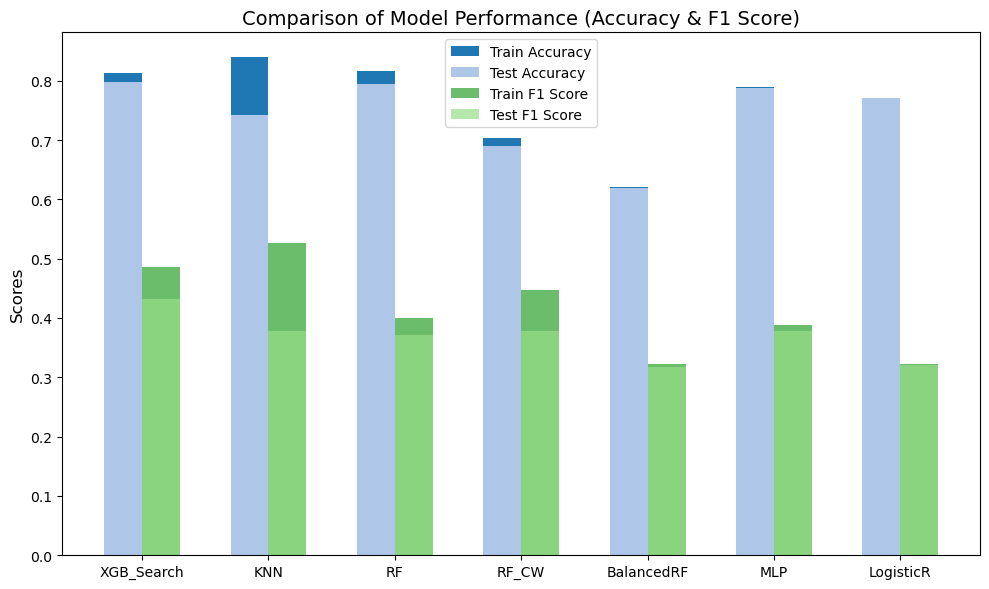

In [139]:
# Set model names from the 'results_models' DataFrame
model_names = results_models.index

# Accuracy and F1 scores from the results DataFrame
train_accuracy = results_models['Train Accuracy']
test_accuracy = results_models['Test Accuracy']
train_f1 = results_models['Train F1 Score']
test_f1 = results_models['Test F1 Score']

# Bar width
bar_width = 0.3
index = np.arange(len(model_names))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Train Accuracy, Test Accuracy, Train F1 Score, and Test F1 Score
bar_tra = ax.bar(index - bar_width / 2, train_accuracy, bar_width, label='Train Accuracy', color='#1F77B4' )
bar_ta = ax.bar(index - bar_width / 2, test_accuracy, bar_width, label='Test Accuracy', color='#AEC7E8')

bar_trf = ax.bar(index + bar_width / 2, train_f1, bar_width, label='Train F1 Score', alpha=0.7, color= '#2CA02C' )
bar_tf = ax.bar(index + bar_width / 2, test_f1, bar_width, label='Test F1 Score', alpha=0.7, color='#98DF8A')

# Labeling the plot
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performance (Accuracy & F1 Score)', fontsize=14)

# Set the model names on the x-axis from 'results_models' index
ax.set_xticks(index)
ax.set_xticklabels(model_names)

# Display the legend
ax.legend()

# Show the plot with tight layout to ensure no labels are cut off
plt.tight_layout()
plt.show()


The model with best F1-Score (macro) is XGB therefore this will be the model explored the most in the next notebook with cross validation and different strategies to fight class imbalance.